In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statistics

import data_cleaning

# Data loading / cleaning

## Loading..

In [2]:
#POAP data
poap = data_cleaning.get_cleaned_poap_data()

#DAOHaus data
dh_members, dh_proposals, dh_votes = data_cleaning.get_daohaus_cleaned_data()

#Snapshot data
snap_proposals, snap_votes, snap_creation = data_cleaning.get_snapshot_cleaned_data()

In [72]:
# Trying to measure how much of these popular events on 2021 are NFT related

poap['is_nft_related'] = False
poap.loc[(poap.event_name.str.contains('nft', case=False) )|
     (poap.event_description.str.contains('nft', case=False)) |
     (poap.event_url.str.contains('nft', case=False)), 'is_nft_related'] = True


In [73]:
poap.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3685249 entries, 0 to 3705199
Data columns (total 31 columns):
token_created          int64
event_created          int64
event_id               int64
event_tokenCount       int64
event_transferCount    int64
token_id               int64
owner_id               object
token_transferCount    int64
chain                  object
event_fancy_id         object
event_name             object
event_url              object
event_image_url        object
event_country          object
event_city             object
event_description      object
event_year             int64
event_start_date       object
event_end_date         object
event_expiry_date      object
event_from_admin       bool
virtual_event          bool
event_template_id      int64
event_host_id          int64
private_event          bool
owner_id_checksum      object
mint_timestamp         datetime64[ns]
mint_date              object
mint_year              int64
has_event_url          boo

In [10]:
from datetime import datetime

#creating mint dates
poap['mint_timestamp'] = poap['token_created'].apply(lambda t: datetime.fromtimestamp(t) )
poap['mint_date'] = poap['mint_timestamp'].dt.date
poap['mint_year'] = poap['mint_timestamp'].dt.year

poap.head()

,token_created,event_created,event_id,event_tokenCount,event_transferCount,token_id,owner_id,token_transferCount,chain,event_fancy_id,...,event_expiry_date,event_from_admin,virtual_event,event_template_id,event_host_id,private_event,owner_id_checksum,mint_timestamp,mint_date,mint_year
0,1558995074,1558995074,14,84,96,1,0xea5ce2f9a33d36534ee3409d81322feb3f91ed8a,1,ethereum,ethdenver-19,...,19-Mar-2019,True,False,0,0,False,0xeA5ce2F9a33D36534eE3409D81322feb3F91ED8a,2019-05-27 16:11:14,2019-05-27,2019
1,1558995074,1558995074,14,84,96,10,0xa3f0d54a263520375e01c17b8ffbd3190745bbd9,1,ethereum,ethdenver-19,...,19-Mar-2019,True,False,0,0,False,0xA3F0d54A263520375E01C17B8ffBD3190745BbD9,2019-05-27 16:11:14,2019-05-27,2019
2,1558999607,1558999607,4,28,29,100,0x68f9d801c96ac6ccf562f3600cef77c4504449b6,1,ethereum,devcon2,...,21-Oct-2016,True,False,0,0,False,0x68F9D801C96aC6ccf562f3600Cef77c4504449b6,2019-05-27 17:26:47,2019-05-27,2019
3,1559020637,1559018257,28,316,334,1000,0xdd6f702c2907ce401888d993d7dc185e7a824466,1,ethereum,ethny-19,...,19-Jun-2019,True,False,0,0,False,0xDd6f702C2907ce401888D993D7Dc185e7a824466,2019-05-27 23:17:17,2019-05-27,2019
4,1588548343,1588539431,207,1197,1211,10000,0xcc95fd73c77bb7bb58714688e9333c05a388693e,1,ethereum,virtual-blockchain-week-2020-general-2020,...,02-Jun-2020,False,False,0,0,False,0xcC95fd73C77bB7BB58714688e9333c05A388693e,2020-05-03 17:25:43,2020-05-03,2020


# Analysis

## How many POAP are issued per year

**Different events created**

In [105]:
ev

,event_year,number_of_events
0,0,4
1,2015,1
2,2016,2
3,2017,1
4,2018,17
5,2019,54
6,2020,487
7,2021,14565
8,2022,1846


   event_year  number_of_events          %
0           0                 4   0.023561
1        2015                 1   0.005890
2        2016                 2   0.011781
3        2017                 1   0.005890
4        2018                17   0.100135
5        2019                54   0.318077
6        2020               487   2.868587
7        2021             14565  85.792543
8        2022              1846  10.873535


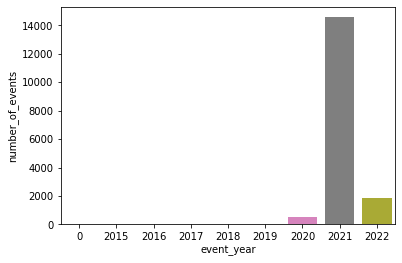

In [107]:
ev = poap.groupby('event_year').agg(number_of_events=('event_id', 'nunique')).reset_index()
ev['%'] = (ev['number_of_events'] / ev['number_of_events'].sum()) * 100

print(ev)

sns.barplot(data=ev, x='event_year', y='number_of_events')

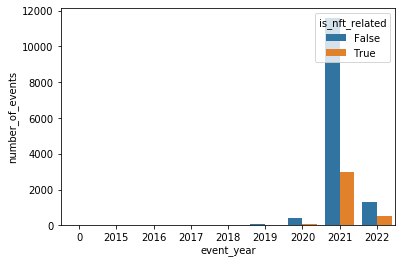

In [74]:
evt = poap.groupby(['event_year', 'is_nft_related']).agg(number_of_events=('event_id', 'nunique')).reset_index()

sns.barplot(data=evt, x='event_year', y='number_of_events', hue='is_nft_related')

**Number of tokens minted**

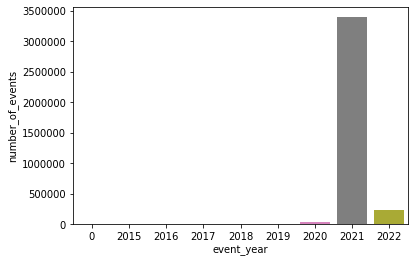

In [12]:
ev = poap.groupby('event_year').agg(number_of_events=('token_id', 'nunique')).reset_index()

sns.barplot(data=ev, x='event_year', y='number_of_events')

### Relatioship with ETH price

In [38]:
# got historical price data from here: https://ca.investing.com/crypto/ethereum/eth-usd-historical-data

custom_date_parser = lambda x: datetime.strptime(x, '%b %d, %Y')
ethprice = pd.read_csv('eth_usd_historical_prices.csv', thousands=',', parse_dates=['Date'], date_parser=custom_date_parser)
ethprice.head(2)

,Date,Price,Open,High,Low,Vol.,Change %
0,2022-02-21,2744.69,2621.87,2748.69,2608.33,438.68K,4.81%
1,2022-02-20,2618.76,2764.39,2764.39,2577.69,386.43K,-5.25%


In [50]:
#getting daily mints
dmints = poap.groupby('mint_date').agg(number_of_mints=('token_id', 'nunique')).reset_index()
dmints['mint_date_adj'] = pd.to_datetime(dmints['mint_date'], infer_datetime_format=True)
dmints.head()

#changing price columns name
ethprice = ethprice.rename(columns={'Price':'eth_price_USD'})

dmints = dmints.merge(ethprice.loc[:, ['Date', 'eth_price_USD']], left_on='mint_date_adj', right_on='Date', how='left')

dmints.head()

,mint_date,number_of_mints,mint_date_adj,Date,eth_price_USD
0,2019-05-27,871,2019-05-27,2019-05-27,270.88
1,2019-05-30,8,2019-05-30,2019-05-30,254.63
2,2019-05-31,3,2019-05-31,2019-05-31,268.01
3,2019-06-13,4,2019-06-13,2019-06-13,254.80
4,2019-06-21,5,2019-06-21,2019-06-21,294.63


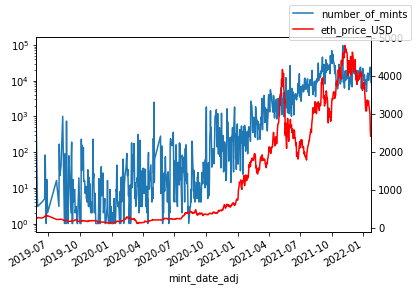

In [85]:
ax = dmints.plot(x="mint_date_adj", y="number_of_mints", legend=False, logy=True)
ax2 = ax.twinx()
dmints.plot(x="mint_date_adj", y="eth_price_USD", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

## Median Number of attendees

In [69]:
mev = poap.groupby(['event_id', 'event_year']).agg(n_attendees=('owner_id', 'nunique')).reset_index()
mevg = mev.groupby('event_year').agg(median_n_attendees=('n_attendees', 'median')).reset_index()

mevg

,event_year,median_n_attendees
0,0,8.0
1,2015,12.0
2,2016,128.5
3,2017,54.0
4,2018,24.0
5,2019,23.0
6,2020,18.0
7,2021,25.0
8,2022,17.0


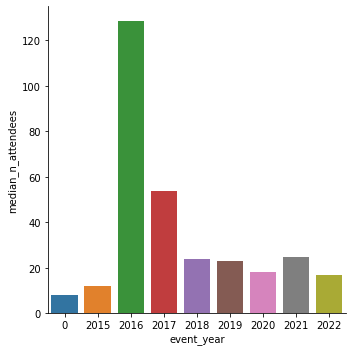

In [70]:
sns.catplot(data=mevg, x='event_year', y='median_n_attendees', kind='bar')

## Median Number of tokens minted per event

In [76]:
mnt = poap.groupby(['event_year', 'event_id']).agg(mint_count=('token_id', 'nunique')).reset_index()

mntf = mnt.groupby('event_year').agg(median_number_of_mints_per_event=('mint_count', 'median')).reset_index()
mntf

,event_year,median_number_of_mints_per_event
0,0,8.0
1,2015,12.0
2,2016,128.5
3,2017,55.0
4,2018,24.0
5,2019,23.0
6,2020,18.0
7,2021,25.0
8,2022,17.0


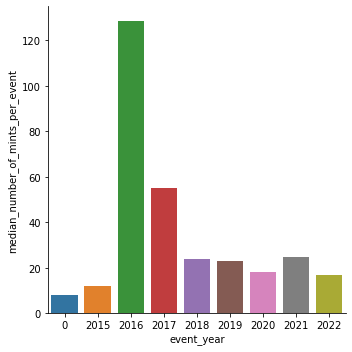

In [78]:
sns.catplot(data=mntf, x='event_year', y='median_number_of_mints_per_event', kind='bar')

## How many issuers

There is a problem here that on POAP contracts that are no event creator identifier and at the same time the host_id on POAP API doesn't seem to be working.. so the only parameter here that might help would be to the events urls

In [64]:
# marking events that have or haven't urls
poap['has_event_url'] = False
poap.loc[poap.event_url != '', 'has_event_url'] = True

he = poap.groupby('has_event_url').agg(event_count=('event_id', 'nunique')).reset_index()
he['%'] = (he.event_count / he.event_count.sum()) * 100

he

,has_event_url,event_count,%
0,False,3737,22.012134
1,True,13240,77.987866


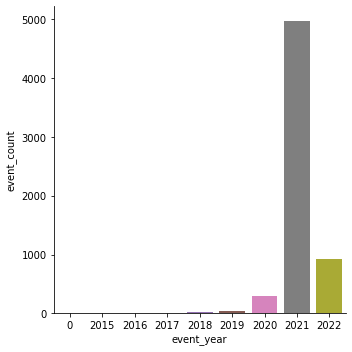

In [66]:
#checking the evolution in the number of issuers

ise = poap.loc[poap.has_event_url==True].groupby('event_year').agg(event_count=('event_url', 'nunique')).reset_index()

sns.catplot(data=ise, x='event_year', y='event_count', kind='bar')

## Most popular events 2021

In [86]:
pop = poap.loc[poap.event_year==2021].groupby(['event_name', 'is_nft_related']).agg(wallet_count=('owner_id', 'nunique')).reset_index()

Non_NFT_Related

In [87]:
pop.loc[pop.is_nft_related==False].sort_values('wallet_count', ascending=False).head(10)

,event_name,is_nft_related,wallet_count
12614,The Mutant Ape’s Demise,False,61208
14194,imToken Security Ambassador POAP,False,31625
6599,Guild of Guardians Founder Badge,False,27819
13298,VeeFriends x Christie's 10/01,False,23512
14444,zkSync Quiz 1,False,23320
5649,Ethereals Moon Mission POAP #4,False,23030
8492,Metamask 10 Million Users Party,False,22716
7125,International Sushi Day 2021,False,22519
1825,Beanie x Farokh Ceasefire,False,21367
9741,POAP x Rocket Pool: Crossover Celebration,False,21345


NFT_Related

In [88]:
pop.loc[pop.is_nft_related==True].sort_values('wallet_count', ascending=False).head(10)

,event_name,is_nft_related,wallet_count
5638,EthStaker Presents: Calm Before The Storm,True,13617
9002,NFTFY Official Launch Party - POAP,True,12742
12483,"The First Redeemable NFT in Times Square, Ever!",True,12397
13946,ZED HQ - Launch - Open Day,True,9105
10227,PolygonLow#1-10 Wearables Party,True,8341
9399,OHALE celebrates Nigeria @ 61,True,7364
8129,Malaysia Blockchain Month (MBM2021) #NFT2 MALA...,True,7049
8131,Malaysia Blockchain Month (MBM2021) #NFT4 DUO,True,6513
12588,The Maserati Collection by Maserati & Automobi...,True,5032
7862,Lucas Samaras XYZ Chinoiserie NFTs on Pace Gal...,True,4990


#### **Comparing the number of mints from nft and non-nft related**

In [98]:
non_nft_related_mean = pop.loc[pop.is_nft_related==False, 'wallet_count'].sum() / len(pop.loc[pop.is_nft_related==False, 'event_name'].unique())
nft_related_mean = pop.loc[pop.is_nft_related==True, 'wallet_count'].sum() / len(pop.loc[pop.is_nft_related==True, 'event_name'].unique())

st, p_value = stats.ttest_ind(pop.loc[pop.is_nft_related==False, 'wallet_count'], 
                              pop.loc[pop.is_nft_related==True, 'wallet_count'],
                             equal_var=False)

print(f"NFT related events have average of {nft_related_mean:.2f} mints \nnon-NFT related events have average of {non_nft_related_mean:.2f} mints")
print(f"p-value for t-test of these means is : {p_value:.4f}")

NFT related events have average of 295.64 mints 
non-NFT related events have average of 214.76 mints
p-value for t-test of these means is : 0.0000


In [101]:
poap.loc[poap.event_name.str.contains('olympusdao', case=False), 'event_name'].unique()

array(['OlympusDAO - FOHMO 2, Day 5 ', 'OlympusDAO x ShapeShiftDAO AMA',
       '"Ohmies get Liquity" | OlympusDAO x Alchemist Crucible | After-party POAP'],
      dtype=object)

In [108]:
295.64/214.76-1

0.3766064444030546